In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random

/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

# Comparison on multiple datasets

In [3]:
import openml
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

In [4]:
import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

In [5]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [6]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [7]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [8]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    #y_test_appended = np.concatenate([y_test,[1]])
    y_test_appended = clf.predict(X_test_appended)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [9]:
shap.initjs()

In [10]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [11]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [12]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

In [13]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            if len((set(v1)|set(v2))) == 0:
                jackard = 0
            else:
                jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

In [14]:
def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f' and {i}{op}'.join(v))
    print(' and '.join(query))
    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

In [15]:
# def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
#     #TODO: calculate stats separtelly fro each class
#     results_mean =[] 
#     results_std =[] 
#     for true_class in rules_and_instances['true_class'].unique():
#         rules = rules_and_instances[rules_and_instances['true_class']==true_class]
#         instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
#         jackart = np.zeros((rules.shape[0],rules.shape[0]))
#         for i in range(rules.shape[0]):
#             for ii in range(rules.shape[0]):
#                 jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
#         stab = jackart/(instance_similarity+1)
#         results_mean.append(np.mean(stab))
#         results_std.append(np.std(stab))
#     return (np.mean(results_mean), np.mean(results_std)) #large stability, low variance is desired

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            if len(set(rule_1.keys())|set(rule_2.keys())) == 0:
                feature_jackart[i,ii] = 0
            else:
                feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired



In [16]:
def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Main comparison loop

## Benchmark, model agnostic

In [17]:
def predict_lux(model,X,y=None):
        if isinstance(X, pd.DataFrame):
            pass
        elif isinstance(X,np.ndarray):
            X = pd.DataFrame(X,columns=model.attributes_names)
        else:
            raise ValueError("Only 2D arrrays are allowed as an input")
            
        if y is None:
            y = pd.Series(np.arange(X.shape[0]),name='target_unused',index=X.index) # This is not used, but Data resered last 
                
        X=pd.concat((X,y),axis=1)
        XData = Data.parse_dataframe(X,'lux')
        return [int(f.get_name()) for f in model.predict(XData.get_instances())]

In [18]:
def generate_lore_dataset(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

OpenML Benchmark Suite
ID..............: 99
Name............: OpenML-CC18 Curated Classification benchmark
Status..........: active
Main Entity Type: task
Study URL.......: https://www.openml.org/s/99
# of Data.......: 72
# of Tasks......: 72
Creator.........: https://www.openml.org/u/1
Upload Time.....: 2019-02-21 18:47:13
Processing kr-vs-kp
Large fsize: skippp: kr-vs-kp
Processing letter
Largeletter size: 1000
letter
Accuracy  model: 0.804 for letter
Train size: 750
----------- Model certainty for instance: 0.6 ---------------
Neighbourhood size: 50
Average distace of neighbourhood: 2.456244869046863.
Neighbourhood size: 50
Average distace of neighbourhood: 2.1472969290521187.


 99%|===================| 4158/4212 [00:56<00:00]        

Size of fulldf: 30
Done 11.0 upsampling
<class 'numpy.ndarray'>
Train sample size: 639 (0.852)


100%|===================| 16625/16640 [02:37<00:00]        

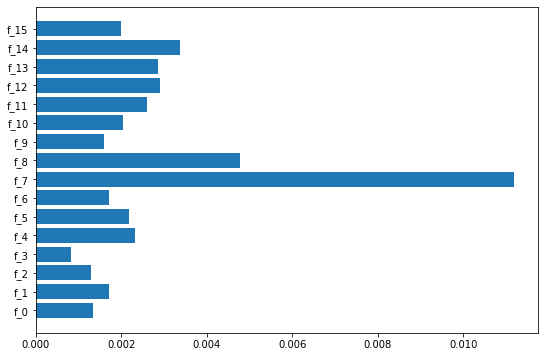

Fidelity  dectree: 0.76
Lux w shap
In fact using: 0.852 samples from train set wiuth class balance: 13.72300469483568


 99%|===================| 9614/9672 [00:46<00:00]          

--- 778.5813250541687 seconds ---
IF f_7 >=0.5247771739959717 AND f_14 <0.4039553701877594 AND f_9 >=-0.7557786405086517 AND f_5 >=-0.22866654302924871 THEN class = 14 # 0.9973118279569892



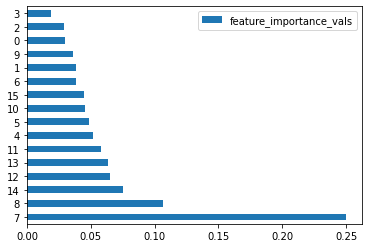

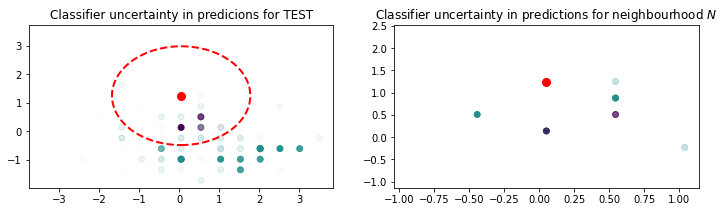

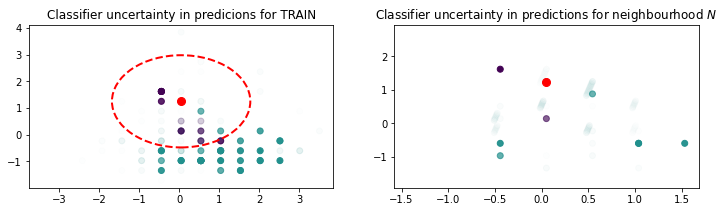

Fidelity  with shap: 0.48
f_7>=0.5247771739959717 and f_14<0.4039553701877594 and f_9>=-0.7557786405086517 and f_5>=-0.22866654302924871
f_7>=0.5247771739959717 and f_14<0.4039553701877594 and f_9>=-0.7557786405086517 and f_5>=-0.22866654302924871
SHAPGAIN LUX:0.09349380854247563
Fidelity  EXPLAN: 0.6
LORE expl e = {'f_15': ['<0.12360955774784088'], 'f_13': ['<0.27361102402210236'], 'f_11': ['<0.4743051826953888', '>=-0.37352901697158813'], 'f_12': ['<1.2865814566612244', '>=-0.6664904952049255'], 'f_7': ['>=0.8739979565143585'], 'f_14': ['<0.6290102303028107', '>=-0.8444302678108215'], 'f_9': ['<1.1517730951309204', '>=-0.8883540332317352'], 'f_8': ['>=-1.5451557040214539'], 'f_10': ['<1.1688362956047058']}
f_15<0.12360955774784088 and f_13<0.27361102402210236 and f_11<0.4743051826953888 and f_11>=-0.37352901697158813 and f_12<1.2865814566612244 and f_12>=-0.6664904952049255 and f_7>=0.8739979565143585 and f_14<0.6290102303028107 and f_14>=-0.8444302678108215 and f_9<1.151773095130920

 98%|===================| 4257/4326 [00:19<00:00]        

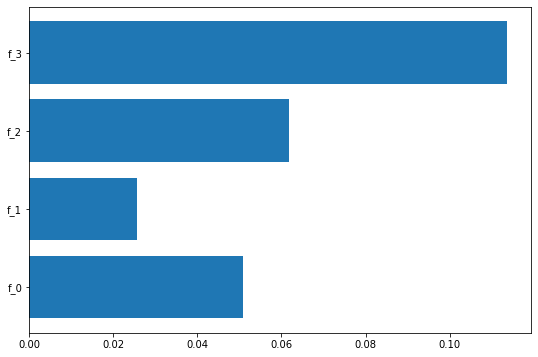

Fidelity  dectree: 0.7419354838709677
Lux w shap
In fact using: 3.0641025641025643 samples from train set wiuth class balance: 0.5083682008368201
--- 87.7916305065155 seconds ---
IF f_3 >=1.0175652503967285 AND f_2 <1.0594207644462585 AND f_0 >=0.3543863445520401 AND f_1 >=0.3822917491197586 THEN class = 0 # 0.9962476547842402



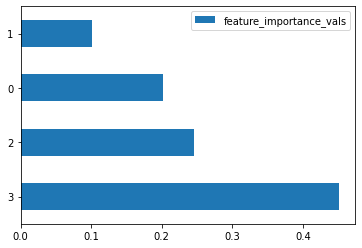

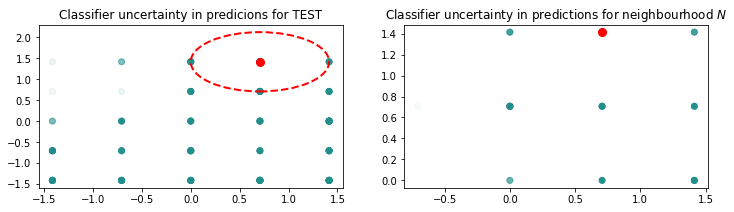

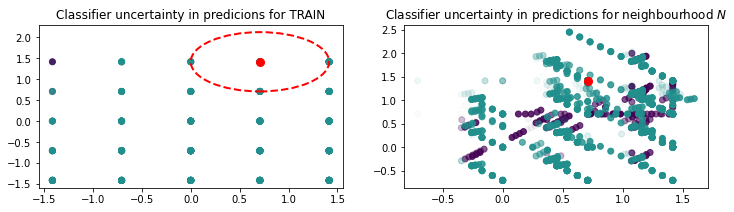

Fidelity  with shap: 0.8709677419354839
f_3>=1.0175652503967285 and f_2<1.0594207644462585 and f_0>=0.3543863445520401 and f_1>=0.3822917491197586
f_3>=1.0175652503967285 and f_2<1.0594207644462585 and f_0>=0.3543863445520401 and f_1>=0.3822917491197586
SHAPGAIN LUX:0.25
Fidelity  EXPLAN: 0.8064516129032258
LORE expl e = {'f_3': ['>=1.3750077486038208'], 'f_2': ['<1.0606601536273956', '>=-0.6860785782337189'], 'f_0': ['<1.0606601536273956', '>=0.3535533845424652'], 'f_1': ['>=0.3535533845424652']}
f_3>=1.3750077486038208 and f_2<1.0606601536273956 and f_2>=-0.6860785782337189 and f_0<1.0606601536273956 and f_0>=0.3535533845424652 and f_1>=0.3535533845424652
f_3>=1.3750077486038208 and f_2<1.0606601536273956 and f_2>=-0.6860785782337189 and f_0<1.0606601536273956 and f_0>=0.3535533845424652 and f_1>=0.3535533845424652
SHAPGAIN explan:0.25
Fidelity  LORE: 0.7419354838709677
LORE expl e = {'f_3': ['>=0.8642338216304779'], 'f_2': ['<1.282116711139679'], 'f_0': ['>=0.24858354032039642'], 'f

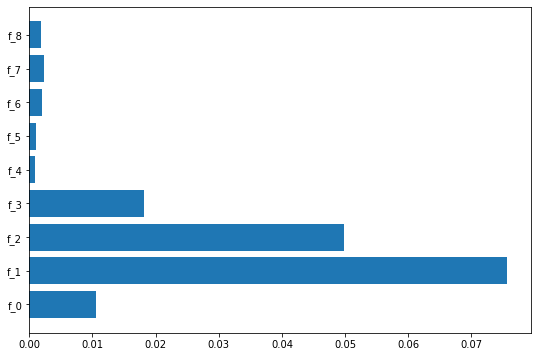

Fidelity  dectree: 0.9846153846153847
Lux w shap
In fact using: 4.66796875 samples from train set wiuth class balance: 0.06652719665271967
--- 94.88589429855347 seconds ---
IF f_6 <-0.034838225692510605 AND f_5 <0.26633764803409576 THEN class = 0 # 0.999514091350826



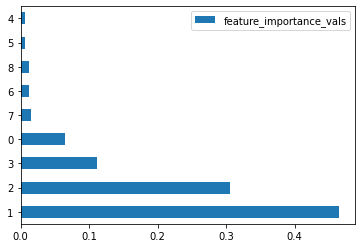

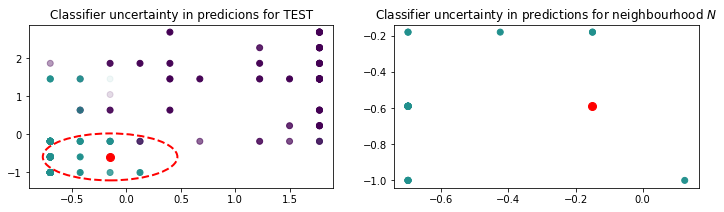

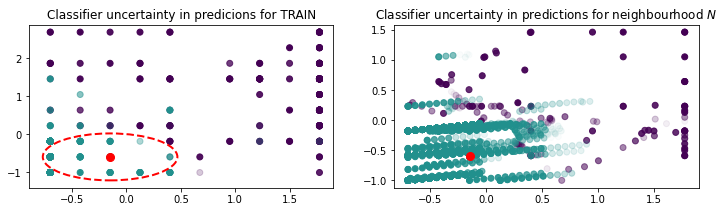

Fidelity  with shap: 0.9850746268656716
f_6<-0.034838225692510605 and f_5<0.26633764803409576
f_6<-0.034838225692510605 and f_5<0.26633764803409576
SHAPGAIN LUX:0.00960986764393795
Fidelity  EXPLAN: 0.9850746268656716
LORE expl e = {'f_6': ['<1.0515518486499786'], 'f_5': ['<0.5943835973739624'], 'f_1': ['<1.4316588044166565']}
f_6<1.0515518486499786 and f_5<0.5943835973739624 and f_1<1.4316588044166565
f_6<1.0515518486499786 and f_5<0.5943835973739624 and f_1<1.4316588044166565
SHAPGAIN explan:0.16151681555583838
Fidelity  LORE: 0.9850746268656716
LORE expl e = {'f_0': ['<0.6865940093994141'], 'f_6': ['<-0.10806780308485031'], 'f_1': ['<0.5287489295005798'], 'f_5': ['<-0.006383017636835575']}
Ats lore: ['f_0', 'f_6', 'f_1', 'f_5']
f_0<0.6865940093994141 and f_6<-0.10806780308485031 and f_1<0.5287489295005798 and f_5<-0.006383017636835575
f_0<0.6865940093994141 and f_6<-0.10806780308485031 and f_1<0.5287489295005798 and f_5<-0.006383017636835575
SHAPGAIN lore:0.1373939636959311
SHAPGAIN

 99%|===================| 4076/4110 [00:32<00:00]        

Size of fulldf: 38
Done 11.0 upsampling
<class 'numpy.ndarray'>
Train sample size: 1077 (1.436)


100%|===================| 10738/10780 [00:57<00:00]        

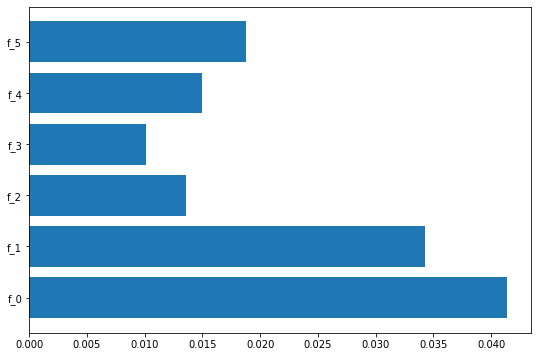

Fidelity  dectree: 0.8000000000000002
Lux w shap
In fact using: 1.428 samples from train set wiuth class balance: 6.300653594771242


 93%|=================== | 2987/3210 [00:13<00:00]       

--- 248.40100169181824 seconds ---
IF f_0 >=1.4934982657432556 THEN class = 8 # 1.0



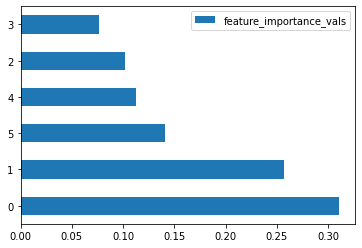

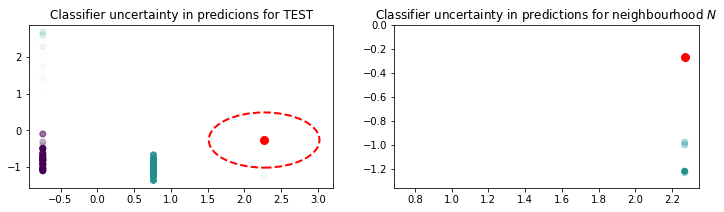

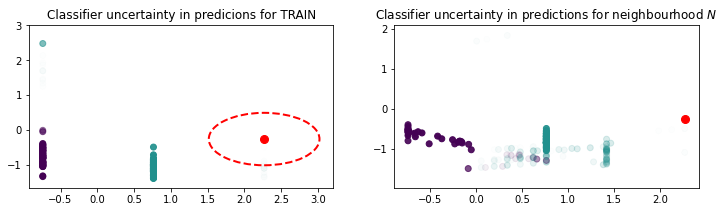

Fidelity  with shap: 0.94
f_0>=1.4934982657432556
f_0>=1.4934982657432556
SHAPGAIN LUX:0.31090177782525025
Fidelity  EXPLAN: 0.82
LORE expl e = {'f_0': ['>=0.7734493017196655'], 'f_5': ['>=-1.1685856580734253'], 'f_1': ['<-1.1344947218894958']}
f_0>=0.7734493017196655 and f_5>=-1.1685856580734253 and f_1<-1.1344947218894958
f_0>=0.7734493017196655 and f_5>=-1.1685856580734253 and f_1<-1.1344947218894958
SHAPGAIN explan:0.2363353558239656
Fidelity  LORE: 0.78
LORE expl e = {'f_0': ['>=1.8242981433868408'], 'f_1': ['<-0.9021651744842529']}
Ats lore: ['f_0', 'f_1']
f_0>=1.8242981433868408 and f_1<-0.9021651744842529
f_0>=1.8242981433868408 and f_1<-0.9021651744842529
SHAPGAIN lore:0.28403174662582603
SHAPGAIN anchor:0.20650520002972456
Anchor explanation: {'f_2': ['>0.41'], 'f_0': ['>0.76']}
f_2>0.41 and f_0>0.76
f_2>0.41 and f_0>0.76
Processing mfeat-zernike
Large fsize: skippp: mfeat-zernike
Processing cmc
Largecmc size: 1000
cmc
Accuracy  model: 0.476 for cmc
Train size: 750
----------

100%|===================| 919/921 [00:12<00:00]        

Size of fulldf: 123
Done 11.0 upsampling
<class 'numpy.ndarray'>
Train sample size: 2158 (2.8773333333333335)


100%|===================| 6475/6477 [01:01<00:00]        

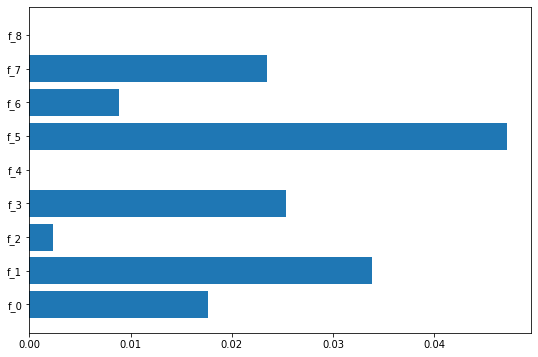

Fidelity  dectree: 0.68
Lux w shap
In fact using: 2.8773333333333335 samples from train set wiuth class balance: 1.7692307692307692


 93%|=================== | 1493/1605 [00:12<00:00]       

--- 408.79921889305115 seconds ---
IF f_0 <0.3597588986158371 AND f_0 >=0.1807425692677498 AND f_6 >=0.20993886142969131 AND f_1 <0.03853106126189232 AND f_5 <0.573685884475708 THEN class = 2 # 1.0



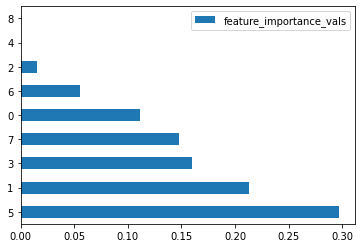

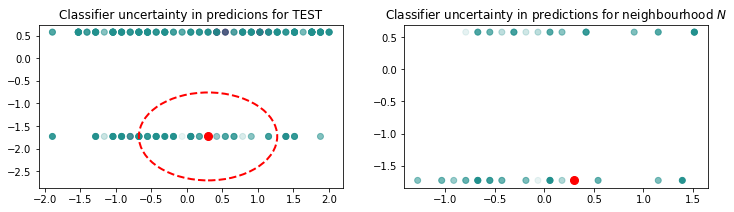

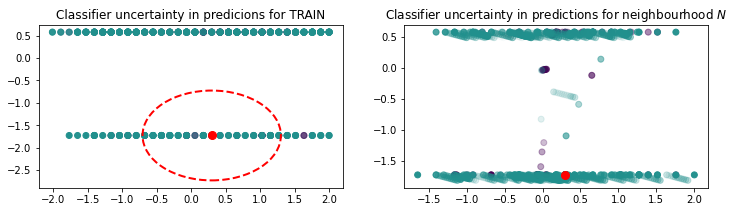

Fidelity  with shap: 0.7
f_0<0.3597588986158371 and f_0>=0.1807425692677498 and f_6>=0.20993886142969131 and f_1<0.03853106126189232 and f_5<0.573685884475708
f_0<0.3597588986158371 and f_0>=0.1807425692677498 and f_6>=0.20993886142969131 and f_1<0.03853106126189232 and f_5<0.573685884475708
SHAPGAIN LUX:0.16932741533968518
Fidelity  EXPLAN: 0.66
LORE expl e = {'f_3': ['<1.3736109733581543', '>=1.1584410667419434'], 'f_2': ['<0.086101233959198'], 'f_0': ['<0.32680700719356537', '>=-0.3694297522306442'], 'f_1': ['<0.0929418932646513'], 'f_5': ['== -1.729702263020778']}
f_3<1.3736109733581543 and f_3>=1.1584410667419434 and f_2<0.086101233959198 and f_0<0.32680700719356537 and f_0>=-0.3694297522306442 and f_1<0.0929418932646513 and f_5== -1.729702263020778
f_3<1.3736109733581543 and f_3>=1.1584410667419434 and f_2<0.086101233959198 and f_0<0.32680700719356537 and f_0>=-0.3694297522306442 and f_1<0.0929418932646513 and f_5== -1.729702263020778
SHAPGAIN explan:0.1592951158462315
Fidelity  

 91%|==================  | 2445/2694 [00:11<00:01]       

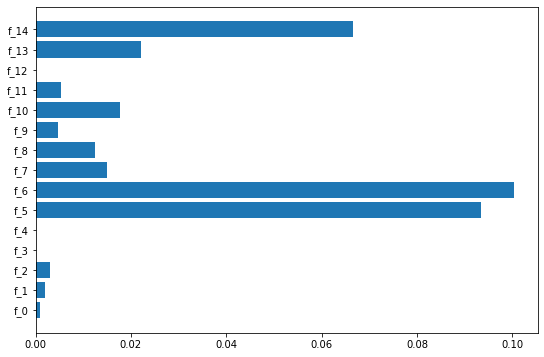

Fidelity  dectree: 0.8979591836734695
Lux w shap
In fact using: 2.644171779141104 samples from train set wiuth class balance: 0.04408352668213457
--- 91.02583980560303 seconds ---
IF f_14 >=-0.156826414167881 AND f_8 <-0.41606508009135723 AND f_6 >=-0.5544791221618652 THEN class = 0 # 1.0



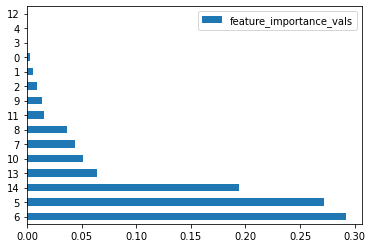

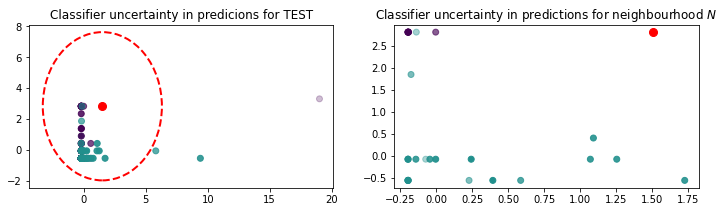

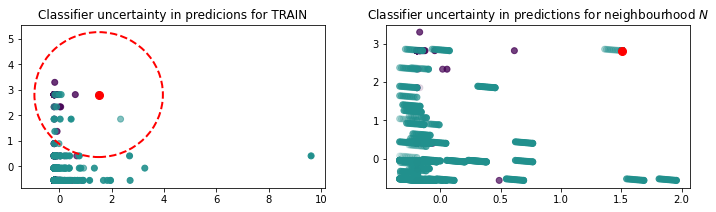

Fidelity  with shap: 0.9166666666666666
f_14>=-0.156826414167881 and f_8<-0.41606508009135723 and f_6>=-0.5544791221618652
f_14>=-0.156826414167881 and f_8<-0.41606508009135723 and f_6>=-0.5544791221618652
SHAPGAIN LUX:0.17393802231489075
Fidelity  EXPLAN: 0.9803921568627451
LORE expl e = {'f_2': ['>=-0.7219188213348389'], 'f_6': ['>=0.97913658618927'], 'f_14': ['>=-0.10513854399323463'], 'f_8': ['<0.016320400638505816']}
f_2>=-0.7219188213348389 and f_6>=0.97913658618927 and f_14>=-0.10513854399323463 and f_8<0.016320400638505816
f_2>=-0.7219188213348389 and f_6>=0.97913658618927 and f_14>=-0.10513854399323463 and f_8<0.016320400638505816
SHAPGAIN explan:0.13269373119924951
Fidelity  LORE: 0.9811320754716981
LORE expl e = {'f_2': ['>=-1.7306684255599976'], 'f_8': ['<0.03653681464493275']}
Ats lore: ['f_2', 'f_8']
f_2>=-1.7306684255599976 and f_8<0.03653681464493275
f_2>=-1.7306684255599976 and f_8<0.03653681464493275
SHAPGAIN lore:0.02261663561543318
SHAPGAIN anchor:0.0912146365948372

 98%|===================| 3863/3938 [00:38<00:00]        

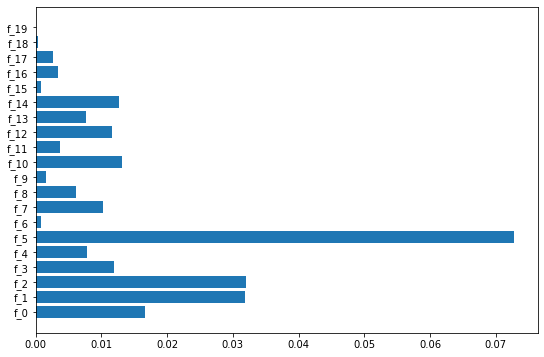

Fidelity  dectree: 0.42857142857142855
Lux w shap
In fact using: 2.624 samples from train set wiuth class balance: 0.8028455284552846


 98%|===================| 1567/1606 [00:16<00:00]        

--- 334.303279876709 seconds ---
IF f_2 <-1.1004002690315247 AND f_5 <1.2128510475158691 AND f_5 >=0.8833405673503876 AND f_12 <-0.5548678189516068 THEN class = 1 # 1.0



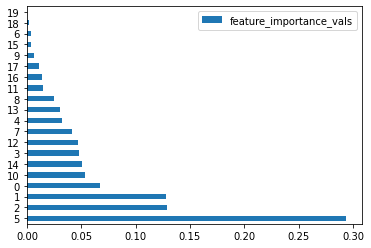

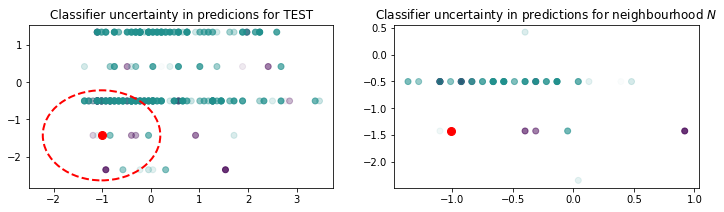

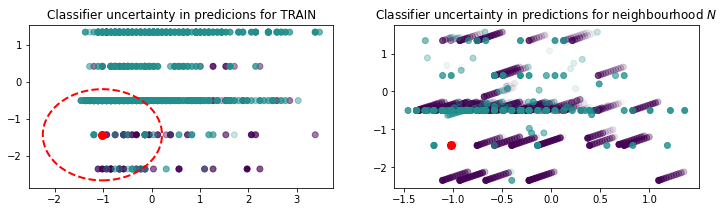

Fidelity  with shap: 0.5128205128205129
f_2<-1.1004002690315247 and f_5<1.2128510475158691 and f_5>=0.8833405673503876 and f_12<-0.5548678189516068
f_2<-1.1004002690315247 and f_5<1.2128510475158691 and f_5>=0.8833405673503876 and f_12<-0.5548678189516068
SHAPGAIN LUX:0.15646575827992376
Fidelity  EXPLAN: 0.5116279069767442
LORE expl e = {'f_17': ['== 2.3348689263480846'], 'f_0': ['== -0.45902623952101795'], 'f_13': ['== -2.375050428691762'], 'f_5': ['== 1.1999500452384142']}
f_17== 2.3348689263480846 and f_0== -0.45902623952101795 and f_13== -2.375050428691762 and f_5== 1.1999500452384142
f_17== 2.3348689263480846 and f_0== -0.45902623952101795 and f_13== -2.375050428691762 and f_5== 1.1999500452384142
SHAPGAIN explan:0.0901021068604976
Fidelity  LORE: 0.3529411764705882
LORE expl e = {'f_3': ['>=0.9342371225357056'], 'f_2': ['<-0.9183466732501984'], 'f_4': ['<-0.4403101056814194'], 'f_11': ['>=-0.9636205434799194'], 'f_12': ['<-0.9461526870727539'], 'f_0': ['<-0.07052842900156975'], 

 99%|===================| 6657/6710 [01:02<00:00]        

Size of fulldf: 76
Done 11.0 upsampling
<class 'numpy.ndarray'>
Train sample size: 1959 (2.612)


100%|===================| 19545/19600 [03:06<00:00]        

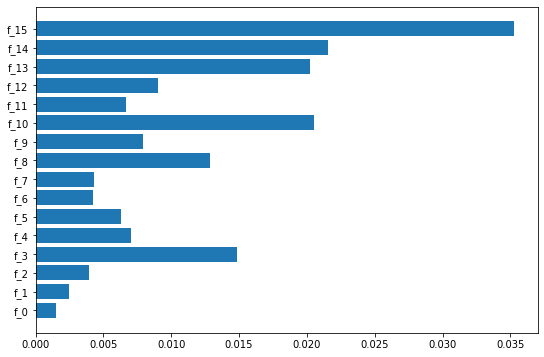

Fidelity  dectree: 0.96
Lux w shap
In fact using: 2.4386666666666668 samples from train set wiuth class balance: 4.83925642427556


 97%|=================== | 8664/8890 [00:11<00:00]        

--- 545.0869674682617 seconds ---
IF f_14 >=0.9996728599071503 AND f_15 >=1.5004648566246033 AND f_13 >=1.390358805656433 THEN class = 5 # 0.99890590809628



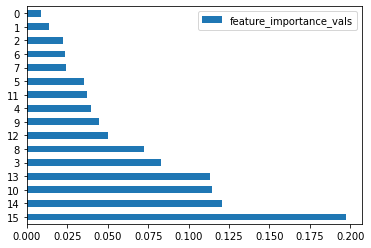

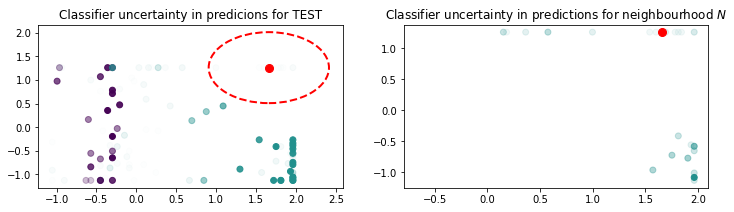

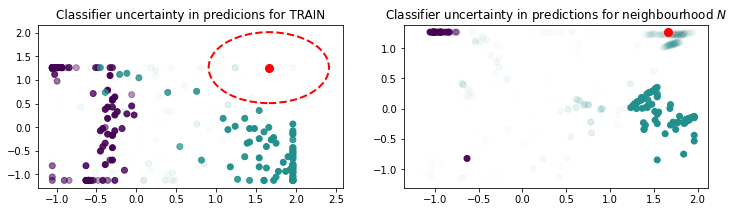

Fidelity  with shap: 0.94
f_14>=0.9996728599071503 and f_15>=1.5004648566246033 and f_13>=1.390358805656433
f_14>=0.9996728599071503 and f_15>=1.5004648566246033 and f_13>=1.390358805656433
SHAPGAIN LUX:0.14377041768279777
Fidelity  EXPLAN: 0.94
LORE expl e = {'f_3': ['<-0.5155991911888123'], 'f_4': ['>=-0.5651309192180634'], 'f_15': ['>=0.6707271039485931'], 'f_11': ['>=-1.0076611936092377'], 'f_12': ['<0.37957876920700073'], 'f_14': ['>=0.14944375306367874'], 'f_10': ['<-1.0882905721664429']}
f_3<-0.5155991911888123 and f_4>=-0.5651309192180634 and f_15>=0.6707271039485931 and f_11>=-1.0076611936092377 and f_12<0.37957876920700073 and f_14>=0.14944375306367874 and f_10<-1.0882905721664429
f_3<-0.5155991911888123 and f_4>=-0.5651309192180634 and f_15>=0.6707271039485931 and f_11>=-1.0076611936092377 and f_12<0.37957876920700073 and f_14>=0.14944375306367874 and f_10<-1.0882905721664429
SHAPGAIN explan:0.09180324026593834
Fidelity  LORE: 0.8399999999999999
LORE expl e = {'f_3': ['<-0.0

 98%|===================| 2987/3054 [00:17<00:00]        

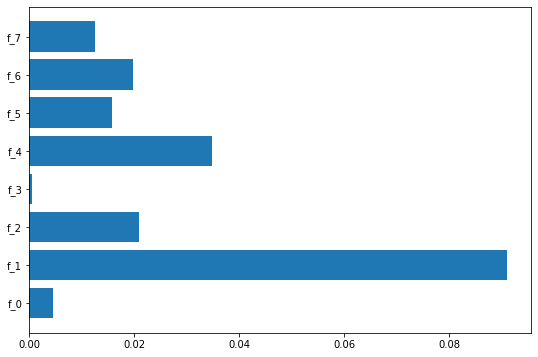

Fidelity  dectree: 0.7222222222222223
Lux w shap
In fact using: 2.6493055555555554 samples from train set wiuth class balance: 0.7640891218872871
--- 96.98769402503967 seconds ---
IF f_7 >=-0.719115287065506 AND f_1 <1.1664785146713257 AND f_1 >=1.1320911049842834 THEN class = 1 # 1.0



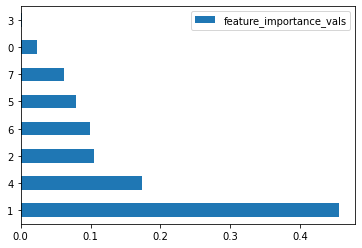

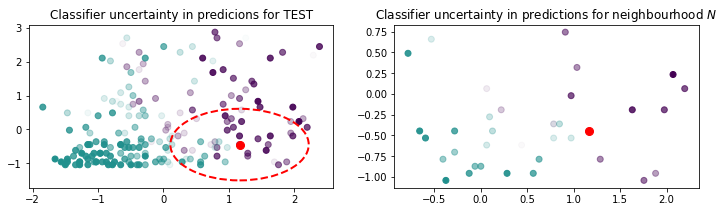

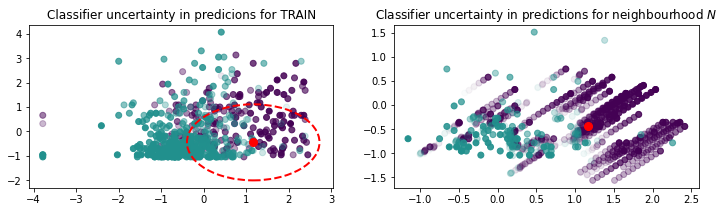

Fidelity  with shap: 0.6857142857142857
f_7>=-0.719115287065506 and f_1<1.1664785146713257 and f_1>=1.1320911049842834
f_7>=-0.719115287065506 and f_1<1.1664785146713257 and f_1>=1.1320911049842834
SHAPGAIN LUX:0.2592093620895297
Fidelity  EXPLAN: 0.8387096774193549
LORE expl e = {'f_6': ['>=-0.915012925863266'], 'f_7': ['>=-0.6132693886756897'], 'f_1': ['>=1.142306923866272']}
f_6>=-0.915012925863266 and f_7>=-0.6132693886756897 and f_1>=1.142306923866272
f_6>=-0.915012925863266 and f_7>=-0.6132693886756897 and f_1>=1.142306923866272
SHAPGAIN explan:0.20566742822589498
Fidelity  LORE: 0.8275862068965517
LORE expl e = {'f_6': ['>=-1.035169005393982'], 'f_7': ['>=-0.746430367231369'], 'f_1': ['>=0.8647849857807159'], 'f_5': ['>=-0.4726838916540146']}
Ats lore: ['f_6', 'f_7', 'f_1', 'f_5']
f_6>=-1.035169005393982 and f_7>=-0.746430367231369 and f_1>=0.8647849857807159 and f_5>=-0.4726838916540146
f_6>=-1.035169005393982 and f_7>=-0.746430367231369 and f_1>=0.8647849857807159 and f_5>=-0.

 98%|===================| 3980/4054 [00:34<00:00]        

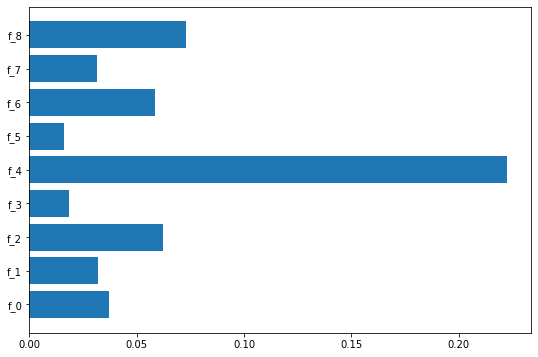

Fidelity  dectree: 0.888888888888889
Lux w shap
In fact using: 2.703342618384401 samples from train set wiuth class balance: 0.17465224111282843


 95%|=================== | 1312/1374 [00:11<00:00]       

--- 181.54317688941956 seconds ---
IF f_2 <0.2991839125752449 AND f_4 <0.2570921257138252 AND f_6 <0.9920578300952911 THEN class = 0 # 1.0



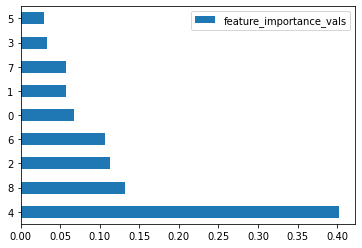

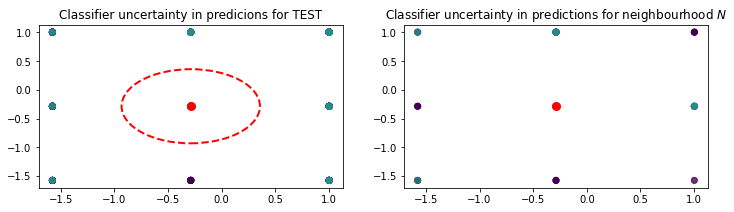

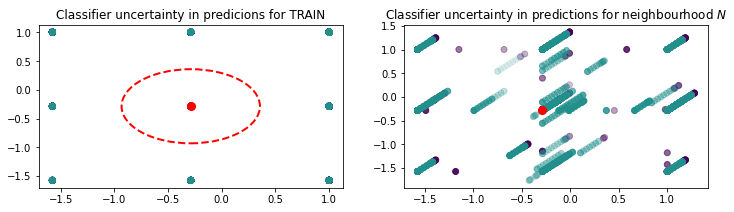

Fidelity  with shap: 0.8648648648648648
f_2<0.2991839125752449 and f_4<0.2570921257138252 and f_6<0.9920578300952911
f_2<0.2991839125752449 and f_4<0.2570921257138252 and f_6<0.9920578300952911
SHAPGAIN LUX:0.2073289405283907
Fidelity  EXPLAN: 0.5714285714285714
LORE expl e = {'f_2': ['== -0.28682739351195713'], 'f_4': ['== -0.4200767905697202'], 'f_6': ['== -0.2868273935119571']}
f_2== -0.28682739351195713 and f_4== -0.4200767905697202 and f_6== -0.2868273935119571
f_2== -0.28682739351195713 and f_4== -0.4200767905697202 and f_6== -0.2868273935119571
SHAPGAIN explan:0.2073289405283907


In [ ]:
import time
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
hits = []
confidences =[]
times=[]
rules = []
rule_coverages = []
rule_coverages_nn = []
rule_local_fid_data_nn = []
rule_local_fid_data = []
explanation_length = []

rs=42
init_fraction=0.2
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
#depth = 2
SAMPLE_SIZE=1
show=False
ismpl=True
oblique=True
synthetic = False
density_sampling=False#True
radius_sampling=False#True
oversampling=True
ostr ='both'
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
node_size_limit = 2
n_jobs=-1
min_generate_samples=0.3

importance_gain_ablation=0
ats_ablation=[]
lux_conf_ablation=0
cov_ablation_nn=acc_ablation_nn=prec_ablation_nn=rec_ablation_nn=f1_ablation_nn =cov_ablation=acc_ablation=prec_ablation=rec_ablation=f1_ablation =0
time_lux_ablation=ac_score_ablation=prec_score_ablation=rec_score_ablation=f1_score_ablation=ac_score_ablation_acc=hit_lux_ablation=0
ablation_lux_elen=0
rule_lux_ablation={}
importance_gain_noproba=0
ats_no_proba=[]
lux_conf_pure=0
cov_pure= acc_pure= prec_pure= rec_pure=f1_pure  =0
cov_pure_nn= acc_pure_nn= prec_pure_nn= rec_pure_nn=f1_pure_nn  =0
time_lux_pure=ac_score_pure=prec_score_pure=rec_score_pure=f1_score_pure=ac_score_pure_acc=hit_lux_pure=0
pure_lux_elen=0
rule_lux_pure={}

importance_gain_with_proba=0
ats_with_proba=[]
lux_conf_proba=0
cov_proba= acc_proba= prec_proba= rec_proba=f1_proba  =0
cov_proba_nn= acc_proba_nn= prec_proba_nn= rec_proba_nn=f1_proba_nn  =0
time_lux_proba=ac_score_proba=prec_score_proba=rec_score_proba=f1_score_proba=ac_score_proba_acc=hit_lux_proba=0
proba_lux_elen=0
rule_lux_proba={}

UId3.PARALLEL_ENTRY_FACTOR = 1000
nf = 4
SYNTH_BREAK=12
progress = []
# for num_and_cat in  os.listdir(directory):
#     progress.append(num_and_cat)
#     rules_temp = []
#     clf_basic  =GradientBoostingClassifier()#MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
#     #clf = svm.SVC(probability=True,random_state=rs)
#     if directory =='./data/numerical_only/balanced':
#         (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
#         features = [f'f_{i}' for i in range(0,data.shape[1])]
#         categorical_indicator=[False]*len(features)
#         clf = clf_basic
#     elif directory =='./data/num_and_cat/balanced':
#         (data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
#         features = [f'f_{i}' for i in range(0,data.shape[1])]
#         density_sampling=False
#         categories_data = data[:,categorical_indicator]
#         categories=[np.unique(categories_data[:,i]).astype(int) for i in np.arange(categories_data.shape[1])]
#         clf = CategoricalWrapper(clf_basic, None, categorical_indicator, features, categories=categories)
suite = openml.study.get_suite(99)
print(suite)
tasks = suite.tasks
skip=True
num=0
for task_id in tasks:
    task = openml.tasks.get_task(task_id)
    num_and_cat = task.get_dataset().name

    # if num_and_cat == 'credit-g':
    #     skip=False
    # if skip:
    #     continue
        
    print('Processing '+num_and_cat)
    
    progress.append(num_and_cat)
    rules_temp = []
    clf_basic  =RandomForestClassifier()#GradientBoostingClassifier()#MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)

    split = task.get_train_test_split_indices()
    data,y= task.get_X_and_y()
    features = [f'f_{i}' for i in range(0,data.shape[1])]
    categorical_indicator=[False]*len(features)
    clf = clf_basic
    
    Xtrain = data[split.train]
    ytrain = y[split.train]
    
    Xtest= data[split.test]
    ytest = y[split.test]

        
    target = 'class'

    
    if synthetic: 
        if nf > SYNTH_BREAK:
            break
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                              n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                              n_classes=2)
        features = [f'f_{i}' for i in range(0,X.shape[1])]
        categorical_indicator=[False]*len(features)
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
        directory='synthetic'
    else:
        continuous_indicator = np.logical_not(categorical_indicator)

        df = pd.DataFrame(data,columns=features,dtype=float)
        sc = StandardScaler()
        df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
        df[target] = y
    
    nf+=1
    depth = len(features)+4

    missing_percentages = df.isnull().mean() * 100

    # Filter columns where missing values exceed 75%
    columns_to_keep = missing_percentages[missing_percentages <= 75].index
    
    # Select only the columns to keep
    df_filtered = df[columns_to_keep]

    features = [f for f in features if f in df_filtered.columns]
    
    df =df.dropna()

    if df.shape[1] > 30:
        print(f'Large fsize: skippp: {num_and_cat}')
        continue
    if len(df) >1000:
        df = df.sample(1000)
        print('Large'+num_and_cat+' size: '+str(len(df)))
        #density_sampling=False
        fraction = init_fraction#1000.0/len(df)
    else:
        #density_sampling=True
        fraction = init_fraction
        
    print(num_and_cat)
    if df[target].nunique() > 2:
        average="micro"
    else:
        average="binary"

    num+=1
    
    #if len(df) < 100:
    #    print(f'error: {num_and_cat}')
    #    continue

    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    print(f'Train size: {len(train)}')
    
    processed_samples = 0
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)
        #explain_instance = test[features].sample(1).values#.astype('f8')    
         
        with open(f'./results/progress.txt', 'w') as fp:
            fp.write('\n'.join(progress))
            fp.write(f'Processed {processed_samples}/100')
        processed_samples +=1
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        nn.fit(train[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh_tr= train.iloc[ids_c.ravel()]
        
        
        start_time = time.time()
        ##############for testing dectree on the bbox sample################
        lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=fraction,max_depth=depth,  min_samples=5,
                  oversampling_strategy=ostr,
                  node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
        X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                  X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                  use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,representative=representative,density_sampling=density_sampling,n_jobs=-1)
        print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
        ###################################################################
        time_lux_gen = time.time() - start_time
        #shap on this sample
        #append pint as a first element and plot force plot
        X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        
    
            
        try:
            explainer = shap.Explainer(clf,X_shap)
            if hasattr(explainer, "shap_values"):
                shap_values = explainer.shap_values(X_shap,check_additivity=False)
            else:
                shap_values = explainer(X_shap).values
                shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            if hasattr(explainer, "expected_value"):
                expected_values = explainer.expected_value
            else:
                expected_values=[np.mean(v) for v in shap_values]
        except TypeError:
            explainer = shap.Explainer(clf.predict_proba, X_shap)
            shap_values = explainer(X_shap).values
            shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
            expected_values=[np.mean(v) for v in shap_values]


        if type(shap_values) is not list:
            shap_values = [-shap_values, shap_values]
            expected_values=[np.mean(v) for v in shap_values]

        
        plt.figure(figsize=(9,6))
        plt.barh(features ,np.abs(shap_values).mean(0)[0])
        plt.show()
        vals = np.abs(shap_values).mean(0)[0]/np.abs(shap_values).mean(0)[0].sum()
        rsv = [sv[1:] for sv in shap_values]
            
        
            
        
        #take N most relevant features and focus only on these when building explanations

        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator+[True])
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))
        feature_importance.plot(kind='barh')
        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                                                #class_names=['0', '1'] ,
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))
            
        pos_label = clf.predict(explain_instance)[0]

        dectree_score =  accuracy_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]))
        dectree_score_prec =  precision_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_rec =  recall_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        dectree_score_f1 =  f1_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average,pos_label=pos_label)
        print(f'Fidelity  dectree: {dectree_score_f1}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        
        #dtree_elen = clf_dtree.decision_path(explain_instance).shape[1]
        
        nodes = np.where(1==clf_dtree.decision_path(explain_instance).todense())[1]
        features_idxs = clf_dtree.tree_.feature[nodes][:-1]
        dtree_ats = list(set(([features[i] for i in features_idxs])))
        dtree_elen = len(dtree_ats)
        
        importance_gain_dtree = shapfeatures[shapfeatures['col_name'].isin(dtree_ats)]['feature_importance_vals'].sum()/len(dtree_ats)
        
        hit_dectree = (clf_dtree.predict(explain_instance)==clf.predict(explain_instance))
        
       
        ########################################################## ###### #######################################################
        ########################################################## LUSX + SHAP #######################################################
        if True:#try:
            print('Lux w shap')
            start_time = time.time()
            #lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=fraction,max_depth=depth,  min_samples=5,
            #      oversampling_strategy='both',
            #      node_size_limit = node_size_limit, grow_confidence_threshold = 0,min_generate_samples=min_generate_samples)
            lux.attributes_names=X_train_sample.columns
           
            
            y_train_sample_proba = lux.predict_proba(X_train_sample)
            hot = np.argmax(y_train_sample_proba,axis=1)
            y_train_sample = np.zeros(y_train_sample_proba.shape)
            for i in range(0,len(y_train_sample)):
                y_train_sample[i,hot[i]] = 1
            #limit features here

            #TODO: filter uncertain samples
            
            threshold_proba = np.max(lux.predict_proba(explain_instance))
            proball = np.max(lux.predict_proba(X_train_sample), axis=1)
            threshold = np.min((np.mean(proball) - 2* np.std(proball), threshold_proba))
            X_train_sample = X_train_sample[proball >= threshold]
            y_train_sample=y_train_sample[proball >= threshold]
            
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=False, depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1, n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)


            try:
                time_lux_shap = time.time() - start_time+time_lux_gen
                print("--- %s seconds ---" % (time_lux_shap))
    
                if show:
                    lux.uid3.tree.save_dot('tree.dot')
                    gvz=graphviz.Source.from_file('tree.dot')
                    display(gvz)
                f1,f2=get_plot_features(lux,explain_instance,all_features = features)
                plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
                plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
                #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
            except:
                print('WARNING: Degenerated explantion, failed to get rule')


            predictions = [int(eval(x.get_name())) for x in lux.uid3.predict(data.instances)]
            ac_score_shap = accuracy_score(clf.predict(dfneigh[features]),predictions)
            prec_score_shap = precision_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            rec_score_shap = recall_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            f1_score_shap = f1_score(clf.predict(dfneigh[features]),predictions, average=average,pos_label=pos_label)
            hit_lux_shap = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])
            print(f'Fidelity  with shap: {f1_score_shap}')
            ac_score_shap_acc = accuracy_score(dfneigh[target],predictions)

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_shap = justification_dict['rule']
            shap_lux_elen = len(justification_dict['rule'].keys())

            cov_shap, acc_shap, prec_shap, rec_shap, f1_shap = coverage_precision(rule_lux_shap, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_shap_nn, acc_shap_nn, prec_shap_nn, rec_shap_nn, f1_shap_nn = coverage_precision(rule_lux_shap, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            justification = lux.justify(explain_instance)[0]
            lux_conf_shap = justification.split("#")[1]
            ats_shap= list(justification_dict['rule'].keys())
            importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
            print(f'SHAPGAIN LUX:{importance_gain_shap}')
        
        
        ########################################################## ###### #######################################################
        ########################################################## EXPLAN #######################################################
        #X_train_sample['class'] = np.argmax(y_train_sample,axis=1)
        try:
            start_time = time.time()
            myds = prepare_ds(train,discrete=categorical_indicator)
            #myds = prepare_ds(dfneigh_tr,discrete=categorical_indicator)
            X, y = myds['X'], myds['y']
            instance2explain = explain_instance.ravel()

            # EXPLAN hyper-parameters
            N_samples = 3000#n_neighbors
            tau = 250#int(n_neighbors)/len(np.unique(df[target])

            # Explaining instance x using EXPLAN
            # exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
            #                                            clf,
            #                                            myds,
            #                                            N_samples=N_samples,
            #                                            tau=tau,depth=depth)

            dense_samples = DataGeneration(instance2explain, clf, myds, 3000)
            # Representative data selection step
            representative_samples = DataSelection(instance2explain, clf, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(clf, representative_samples, myds)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = clf.predict(Ndf[features])

            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs)

            time_explan = time.time() - start_time

            #explan_y=pyyadt.predict(info_EXPLAN['C'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
            explan_y=predict_lux(uid3,dfneigh[features])
            ac_score_explan = accuracy_score(clf.predict(dfneigh[features]),explan_y)
            prec_score_explan = precision_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            rec_score_explan = recall_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)
            f1_score_explan = f1_score(clf.predict(dfneigh[features]),explan_y, average=average,pos_label=pos_label)

            print(f'Fidelity  EXPLAN: {f1_score_explan}')
            ac_score_explan_acc = accuracy_score(dfneigh[target],explan_y)
        

            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            

            rule_EXPLAN = justification_dict['rule']
            explan_elen = len(justification_dict['rule'].keys())
            hit_explan = clf.predict(explain_instance)==int(justification_dict['prediction'])

            print('LORE expl e = %s' % rule_EXPLAN)


            cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_EXPLAN_nn, acc_EXPLAN_nn, prec_EXPLAN_nn, rec_EXPLAN_nn, f1_EXPLAN_nn = coverage_precision(rule_EXPLAN, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')


            ats_explan = list(justification_dict['rule'].keys())
            explan_elen = len(ats_explan)
            importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)
            print(f'SHAPGAIN explan:{importance_gain_explan}')
        except:
            cov_EXPLAN=acc_EXPLAN=prec_EXPLAN=rec_EXPLAN=f1_EXPLAN=explan_elen = importance_gain_explan = prec_score_explan =rec_score_explan=f1_score_explan=ac_score_lore_explan=time_explan = np.nan
            cov_EXPLAN_nn= acc_EXPLAN_nn= prec_EXPLAN_nn= rec_EXPLAN_nn= f1_EXPLAN_nn =np.nan
            rule_EXPLAN={}
            ats_explan=[]
        
        
        ########################################################## ###### #######################################################
        ########################################################## LORE #########################################################
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            # exp_LORE, info_LORE = lore.explain(0, X_explain,
            #                                    myds, clf,
            #                                    ng_function=genetic_neighborhood,
            #                                    discrete_use_probabilities=True,
            #                                    continuous_function_estimation=False,
            #                                    returns_infos=True, path='./EXPLAN/yadt/',
            #                                    sep=';', log=True, depth=depth)
            
            Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,ng_function=genetic_neighborhood, discrete_use_probabilities=True, continuous_function_estimation=False)
            
            datalore = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(datalore,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs)
            #rnum_lore = len(uid3.tree.to_dict())
            #crgen,mg,numfan,prop = coverage_rules(uid3.tree, Zdf, train,features=features)
         
            time_lore = time.time() - start_time
            #lore_y=pyyadt.predict(info_LORE['dt'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
            
            lore_y = predict_lux(uid3,dfneigh[features])
            ac_score_lore = accuracy_score( clf.predict(dfneigh[features]),lore_y)

            prec_score_lore = precision_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            rec_score_lore = recall_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            f1_score_lore = f1_score(clf.predict(dfneigh[features]),lore_y, average=average,pos_label=pos_label)
            
            hit_lore = (clf.predict(explain_instance)==lore_y[0])
            print(f'Fidelity  LORE: {f1_score_lore}')
            ac_score_lore_acc = accuracy_score(dfneigh[target],lore_y)

            
            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_LORE = justification_dict['rule']
            lore_elen = len(justification_dict['rule'].keys())
            
            print('LORE expl e = %s' % rule_LORE)
                
            ats_lore= list(justification_dict['rule'].keys())
            print(f'Ats lore: {ats_lore}')
            cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            cov_LORE_nn, acc_LORE_nn, prec_LORE_nn, rec_LORE_nn, f1_LORE_nn = coverage_precision(rule_LORE, dfneigh, features, categorical_indicator, justification_dict['prediction'], class_label='class')
            
            importance_gain_lore = shapfeatures[shapfeatures['col_name'].isin(ats_lore)]['feature_importance_vals'].sum()/len(ats_lore)
            print(f'SHAPGAIN lore:{importance_gain_lore}')
        except:
            cov_LORE=acc_LORE=prec_LORE=rec_LORE=f1_LORE =lore_elen = importance_gain_lore = prec_score_lore =rec_score_lore=f1_score_lore=ac_score_lore_acc=time_lore=np.nan
            cov_LORE_nn= acc_LORE_nn= prec_LORE_nn= rec_LORE_nn= f1_LORE_nn = np.nan
            rule_LORE={}
            ats_lore=[]
            hit_lore=0
            print('LORE failed...')

        
        ########################################################## ###### #######################################################
        ########################################################## ANCHOR #######################################################
        
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            #anchor_explainer = fit_anchor(myds, train[features], test[features], train[target], test[target], X_explain)
            anchor_explainer = fit_anchor(myds, train[features], train[features], train[target], train[target], X_explain)
            exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                        clf.predict, threshold=np.max([0.5]+[f for f in [prec_score_lore,prec_score_explan, prec_score_shap, prec_score_proba, prec_score_pure] if f is not np.nan]))

            time_anchor= time.time() - start_time
            anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
            ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]
            importance_gain_anchor = shapfeatures[shapfeatures['col_name'].isin(ats_anchor)]['feature_importance_vals'].sum()/len(ats_anchor)
            print(f'SHAPGAIN anchor:{importance_gain_anchor}')

            #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
            #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
            #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
            #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

            rule_Anchor_full = anchor2arule(exp_Anchor)
            rule_Anchor={}
            for i,v in rule_Anchor_full.items():
                if i in ats_anchor[:anch_depth+1]:
                    rule_Anchor[i]=[v]

            dfXExplain = build_df2explain(clf, X_explain, myds)
            cv = get_covered(rule_Anchor_full, dfXExplain.to_dict('records'), myds)
            if len(cv) != 0:
                hit_anchor = (cv[0] == 0)
            else:
                hit_anchor=0
            rule_Anchor = split_rule_conditions(rule_Anchor)
            print(f'Anchor explanation: {rule_Anchor}')
            anchor_elen = len(ats_anchor)
            cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, categorical_indicator, pos_label, class_label='class')
            cov_anchor_nn, acc_anchor_nn, prec_anchor_nn, rec_anchor_nn, f1_anchor_nn = coverage_precision(rule_Anchor, dfneigh, features, categorical_indicator, pos_label, class_label='class')
        except:
            print('Anchor failed...')
            cov_anchor=acc_anchor=prec_anchor=rec_anchor= f1_anchor=anchor_elen = hit_anchor=importance_gain_anchor=time_anchor=np.nan
            cov_anchor_nn= acc_anchor_nn= prec_anchor_nn= rec_anchor_nn= f1_anchor_n=np.nan
            rule_Anchor={}
    

        ########################################################## ###### #######################################################
        ########################################################## ###### #######################################################
        
        
        rules.append([num_and_cat,directory,explain_instance,rule_lux_ablation, rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])
        rules_temp.append([explain_instance,clf.predict(explain_instance)[0],rule_lux_ablation,rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])

        features_data.append([num_and_cat,directory,shapfeatures['col_name'].values,ats_ablation,ats_no_proba,ats_with_proba,ats_shap,ats_explan])
        
        times.append([num_and_cat,directory,time_lux_ablation,time_lux_pure, time_lux_proba, time_lux_shap, time_explan, time_lore, time_anchor])
        
        imp_fid_data.append([num_and_cat,directory,importance_gain_dtree,importance_gain_ablation,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan,importance_gain_lore,importance_gain_anchor])
        
        hits.append([num_and_cat,directory,model_score,instance_certainty_clf,hit_dectree, hit_lux_ablation,hit_lux_pure, hit_lux_proba, hit_lux_shap, hit_explan, hit_lore, hit_anchor])
        
        confidences.append([num_and_cat,directory,model_score,instance_certainty_clf,lux_conf_ablation,lux_conf_pure, lux_conf_proba, lux_conf_shap])
        
        fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                         dectree_score,ac_score_ablation,ac_score_pure,ac_score_proba,ac_score_shap,ac_score_explan,ac_score_lore,
                        dectree_score_prec,prec_score_ablation,prec_score_pure,prec_score_proba,prec_score_shap,prec_score_explan,prec_score_lore, 
                        dectree_score_rec,rec_score_ablation,rec_score_pure,rec_score_proba,rec_score_shap,rec_score_explan,rec_score_lore,
                        dectree_score_f1,f1_score_ablation,f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan,f1_score_lore])
        nac_data.append([num_and_cat,directory,instance_certainty_clf,ac_score_ablation_acc,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc,ac_score_lore_acc
                         ])
        rule_coverages.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation,cov_pure, cov_proba, cov_shap, cov_EXPLAN, cov_LORE, cov_anchor])
        rule_local_fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation,acc_pure, acc_proba, acc_shap, acc_EXPLAN, acc_LORE, acc_anchor,
                              prec_ablation,prec_pure, prec_proba, prec_shap, prec_EXPLAN, prec_LORE, prec_anchor,
                              rec_ablation,rec_pure, rec_proba, rec_shap, rec_EXPLAN, rec_LORE, rec_anchor,
                              f1_ablation,f1_pure, f1_proba, f1_shap, f1_EXPLAN, f1_LORE, f1_anchor
                             ])
        
        rule_coverages_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation_nn,cov_pure_nn, cov_proba_nn, cov_shap_nn, cov_EXPLAN_nn, cov_LORE_nn, cov_anchor_nn])
        rule_local_fid_data_nn.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation_nn,acc_pure_nn, acc_proba_nn, acc_shap_nn, acc_EXPLAN_nn, acc_LORE_nn, acc_anchor_nn,
                              prec_ablation_nn,prec_pure_nn, prec_proba_nn, prec_shap_nn, prec_EXPLAN_nn, prec_LORE_nn, prec_anchor_nn,
                              rec_ablation_nn,rec_pure_nn, rec_proba_nn, rec_shap_nn, rec_EXPLAN_nn, rec_LORE_nn, rec_anchor_nn,
                              f1_ablation_nn,f1_pure_nn, f1_proba_nn, f1_shap_nn, f1_EXPLAN_nn, f1_LORE_nn, f1_anchor_nn
                             ])
        
        explanation_length.append([num_and_cat,directory,model_score,instance_certainty_clf,dtree_elen, ablation_lux_elen,pure_lux_elen, proba_lux_elen, shap_lux_elen, explan_elen, lore_elen, anchor_elen])
        
    ## calculate stability here
    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])
    stab_stats = [stability_stats(results_rules, rid, train, features, categorical_indicator) for rid in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']]
    stability_data.append([num_and_cat,directory]+list(np.concatenate(stab_stats)))
    
    ## save results       

In [ ]:
num

## Results visualization

In [ ]:
data_prefix = './results/openmlx100_deep_oblique_shap_discount_3/'

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','dectree_score',
                                             'ac_score_ablation','ac_score_pure','ac_score_proba','ac_score_shap',  'ac_score_explan','ac_score_lore',
                                             'dectree_score_prec','prec_score_ablation','prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                        'dectree_score_rec','rec_score_ablation','rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                        'dectree_score_f1','f1_score_ablation','f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore'])#.fillna(0)
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))
results_fid.to_csv(data_prefix+"synthx100_scores.csv",index=False)

In [ ]:
results_fid

In [ ]:
results_fid.isna().sum()/results_fid.shape[0]

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid, notch=True,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_fid.groupby('dataset').mean().mean().sort_values()

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid.groupby('dataset').mean(), notch=False,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
print('asd')

In [ ]:
results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_dtree','importance_gain_ablation','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor'])#.fillna(0)
#results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))    
results_imp_fid.to_csv(data_prefix+"synthx100_importance_gain.csv",index=False)

In [ ]:
#one-shot
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=False,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_imp_fid.groupby('dataset').mean().mean().sort_values()

In [ ]:
results_hits = pd.DataFrame(hits,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','hits_dectree','hits_lux_ablation','hits_lux_pure', 'hits_lux_proba', 'hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'], dtype='f8')#.fillna(0)
results_hits.to_csv(data_prefix+"synthx100_hits.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_hits.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


In [ ]:
results_times = pd.DataFrame(times,columns=['dataset','num_and_cat','time_lux_ablation','time_lux_pure', 'time_lux_proba', 'time_lux_shap', 'time_explan', 'time_lore', 'time_anchor'], dtype='f8')#.fillna(0)
results_times.to_csv(data_prefix+"synthx100_times.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_times.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)



In [ ]:
results_conf = pd.DataFrame(confidences,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','lux_conf_ablation','lux_conf_pure', 'lux_conf_proba', 'lux_conf_shap'], dtype='f8')#.fillna(0)
results_conf.to_csv(data_prefix+"synthx100_confidences.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.lineplot(data=results_conf.groupby('dataset').mean().set_index('instance_certainty_clf'),ax=ax)
plt.xticks(rotation=90)



In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_conf.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)


In [ ]:
results_rules = pd.DataFrame(rules, columns=['dataset','num_and_cat','explain_instance','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])#.fillna(0)
results_rules.to_csv(data_prefix+"synthx100_rules.csv",index=False)

In [ ]:
columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_stab_data.to_csv(data_prefix+"synthx100_stability.csv",index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_stab_data.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_nac = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_ablation_acc','ac_score_pure_acc','ac_score_proba_acc','ac_score_shap_acc', 'model_score', 'dectree_score_acc','ac_score_explan_acc','ac_score_lore_acc'
                         ], dtype='f8')#.fillna(0)
results_nac.to_csv(data_prefix+"synthx100_nac.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_nac.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)


In [ ]:
results_rulecov = pd.DataFrame(rule_coverages,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov.to_csv(data_prefix+"synthx100_rulecov.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_rulecov_nn = pd.DataFrame(rule_coverages_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8')#fillna(0)
results_rulecov_nn.to_csv(data_prefix+"synthx100_rulecov_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')
results_local_fid.isna().sum()/results_local_fid.shape[0]

In [ ]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid.to_csv(data_prefix+"synthx100_local_fid.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
results_local_fid_nn = pd.DataFrame(rule_local_fid_data_nn,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8')#.fillna(0)
results_local_fid_nn.to_csv(data_prefix+"synthx100_local_fid_nn.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid_nn.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)

In [ ]:
exp_elen = pd.DataFrame(explanation_length,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                            'dtree_elen', 'ablation_lux_elen','pure_lux_elen', 'proba_lux_elen', 
                                                            'shap_lux_elen', 'explan_elen', 'lore_elen', 'anchor_elen'], dtype='f8')#.dropna()#fillna(0)
exp_elen.to_csv(data_prefix+"synthx100_rulelen.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=exp_elen.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)

In [ ]:
Untitled Folder

In [ ]:
X_train_sample.iloc[[len(X_train_sample)-1]]

In [ ]:
print('ok')

In [ ]:
X_train_sample.append(instance2explain)